In [39]:
import itertools, sympy, numpy as np
from IPython.display import Math
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# SINDy- Sparse Identification of Nonlinear Dynamics
***
Given we have a measurement $\vec{x} = [x,y,z]$ and we know how $\vec{x}$ changes in time, we might want to construct a model that describes observed dynamics.

Generic dynamical system can be expressed as $$\frac{d}{dt}\vec{x} = \vec{f}(\vec{x})$$
Where $\vec{f}$ is a nonlinear function/operator on measurements
***

In a similar fashion as Koopman operator, we might transform linear measurements $[x,y,z]$ into hilbert space of <br>
nonlinear functions $[f_1(x,y,z),f_2(x,y,z),\dots]$.

We select a limited 'library' of such functions and express $\vec{f}(\vec{x})$ as a linear combination in this basis:
$$\vec{f}(\vec{x}) \approx \sum_{k=1}^p \theta_k(\vec{x}) \xi_k = \Theta(\vec{x}) \vec{\xi}$$

For example: $$\{\theta_n\}=\Theta = [1, x, y, z, x^2, y^2, z^2, xy,xz,..., x^n,...,\mathrm{sin}(x),..]$$

As usual, we want to search for the sparsest solution $\vec{\xi}$ which, with a given $\Theta$, approximates $\vec{f}(\vec{x})$ the best.

$$\vec{\xi}_k = \underset{\vec{\xi}_k^\prime}{\mathrm{argmin}}\lVert\frac{d}{dt}\vec{x} - \Theta(\vec{x})\vec{\xi}_k^\prime\rVert_2 + \lambda \lVert \vec{\xi}_k^\prime \rVert$$
Where $k \in [x,y,z]$, so $\vec{\xi}_k$ contains coeficients for each component
***

### Generate linear and non-linear terms of powers x,y,z that add up to 'max_pow'

i.e max_pow = 2 -> [x*x, x*y, x*z, y*y,...] -> [(2,0,0), (1,1,0),(1,0,1),(0,2,0),...]

In [25]:
from sympy.abc import x,y,z

library = []
max_pow = 2
for k in range(max_pow+1):
    powers = [a for a in itertools.product(range(k+1), repeat=3) if sum(a)==k]
    print(k,powers)
    [library.append(sympy.Pow(x,px)*sympy.Pow(y,py)*sympy.Pow(z,pz)) for px,py,pz in powers]

display(Math(sympy.latex(library)))
lib_funcs = [np.vectorize(sympy.lambdify([x,y,z],fn)) for fn in library]

0 [(0, 0, 0)]
1 [(0, 0, 1), (0, 1, 0), (1, 0, 0)]
2 [(0, 0, 2), (0, 1, 1), (0, 2, 0), (1, 0, 1), (1, 1, 0), (2, 0, 0)]


<IPython.core.display.Math object>

### Solve Lorentz system for x,y,z
<i>See: data_processing\differential_equations\ODE_01.ipynb</i>

In [74]:
def ode(v,t, sigma, rho, beta):
    x,y,z = v
    dxdt = sigma*(y-x)
    dydt = x*(rho-z) - y
    dzdt = x*y - beta*z
    return [dxdt, dydt, dzdt]

sigma = 10
rho = 28
beta = 8/3

dt = 0.01; T = 50
t = np.arange(0, T, dt)

np.random.seed(123)
x0 = (-8,8,27)

xyz = odeint(ode, x0, t,rtol=1e-12,atol=1e-12*np.ones_like(x0), args=(sigma, rho, beta))
num_meas, num_vars = xyz.shape
num_meas, num_vars

(5000, 3)

## Test if function library works
Test on $\{x,y\} \in [0,5] \times [0,5]$. 

in order to plot 2D $\forall z=0$, so z = z^2 = y*z = x*z = 0

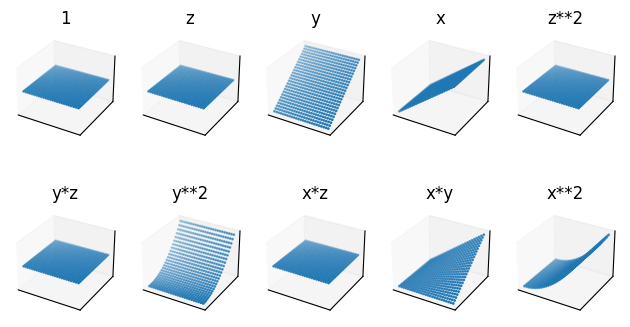

In [71]:
fig, ax = plt.subplots(2,5,subplot_kw=dict(projection='3d'),tight_layout=True, sharex=True, sharey=True)
ax = ax.flatten()
[a.set_xticks([]) for a in ax];
[a.set_yticks([]) for a in ax];
[a.set_zticks([]) for a in ax];
X,Y = np.meshgrid(np.arange(0,5,0.2),np.arange(0,5,0.2))
Z = np.zeros_like(X)
xyz_test = np.repeat(np.arange(0,5,0.2).reshape(-1,1),3, axis = 1)
xyz_test.shape
for i,fn in enumerate(lib_funcs):
    ax[i].scatter(X, Y, fn(X,Y,Z), s = 1)
    ax[i].set_title(library[i])

## Use real x,y,z measurements for $\Theta$

In [72]:
Theta = np.zeros(shape=(num_meas,len(lib_funcs)), dtype=float)#
for i,fn in enumerate(lib_funcs):
    Theta[:,i] = fn(*xyz.T)

## Calculate $[\frac{dx}{dt},\frac{dy}{dt},\frac{dz}{dt}]$
They are LHS of Lorentz system. Cannot properly vectorize it. Have to loop over like in book

In [83]:
dxdt = np.zeros_like(xyz)
for i in range(len(dxdt)):
    dxdt[i] = ode(xyz[i],0, sigma, rho, beta)

Cannot comment of the following. Looks like we purge small coeficients and recalculate.

In [84]:
def sparsifyDynamics(Theta,dXdt,lamb,n):
    Xi = np.linalg.lstsq(Theta,dXdt,rcond=None)[0] # Initial guess: Least-squares
    
    for k in range(10):
        smallinds = np.abs(Xi) < lamb # Find small coefficients
        Xi[smallinds] = 0                          # and threshold
        for ind in range(n):                       # n is state dimension
            biginds = smallinds[:,ind] == 0
            # Regress dynamics onto remaining terms to find sparse Xi
            Xi[biginds,ind] = np.linalg.lstsq(Theta[:,biginds],dXdt[:,ind],rcond=None)[0]
            
    return Xi

## Calculate sparse coeficients by means of optimization

In [101]:

lamb = 0.025 # sparsification knob lambda
Xi = sparsifyDynamics(Theta,dxdt,lamb,3)

fns = np.array([library]).T
sol = np.array(np.round(Xi,3),dtype=object)
sol = np.hstack((fns,sol))
sol = np.vstack((['fn','dx/dt','dy/dt','dz/dt'],sol))
sympy.Matrix(sol)

Matrix([
[  fn, dx/dt, dy/dt,  dz/dt],
[   1,     0,     0,      0],
[   z,     0,     0, -2.667],
[   y,  10.0,  -1.0,      0],
[   x, -10.0,  28.0,      0],
[z**2,     0,     0,      0],
[ y*z,     0,     0,      0],
[y**2,     0,     0,      0],
[ x*z,     0,  -1.0,      0],
[ x*y,     0,     0,    1.0],
[x**2,     0,     0,      0]])

Original problem was:

$
\begin{cases}
\frac{\mathrm{d}x}{\mathrm{d}t} = \sigma(y-x)   \\
\frac{\mathrm{d}y}{\mathrm{d}t} = x(\rho-z) - y \\
\frac{\mathrm{d}z}{\mathrm{d}t} = x y  - \beta z
\end{cases}
\rightarrow
\begin{cases}
\sigma = 10  \\
\rho = 28 \\
\beta = \frac{8}{3}
\end{cases}
\rightarrow
\begin{cases}
\frac{\mathrm{d}x}{\mathrm{d}t} =  10 y - 10 x \\
\frac{\mathrm{d}y}{\mathrm{d}t} =  28 x - 1xz - 1y\\
\frac{\mathrm{d}z}{\mathrm{d}t} = 1 x y  - 8/3 z
\end{cases}
$